<a href="https://colab.research.google.com/github/LeonGoergen/DocumentClassification/blob/main/classification/Proprietary_Software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependicies

## Imports

In [ ]:
# Data management
import pandas as pd
import os
import json
import numpy as np

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
def calculate_accuracy(y_actu, y_pred):
    return accuracy_score(y_actu, y_pred)

def calculate_precision(y_actu, y_pred,average='macro'):
    return precision_score(y_actu, y_pred,average=average)

def calculate_recall(y_actu, y_pred,average='macro'):
    return recall_score(y_actu, y_pred,average=average)

def calculate_f1(y_actu, y_pred,average='macro'):
    return f1_score(y_actu, y_pred,average=average)

def save_results(metrics, algorithm, method):
    name = "/content/drive/MyDrive/Bachelor Thesis/Classification/Proprietary Results/" + algorithm + method + ".json"
    with open(name, "w") as outfile:
        json.dump(metrics, outfile)

def evaluate_model(y_actu, y_pred, time, training_time, algorithm, method=""):
    metrics = {}
    metrics["Algorithm"] = algorithm
    metrics["Method"] = method
    metrics["Accuracy"] = round(calculate_accuracy(y_actu, y_pred)*100, 4)
    metrics["Precision (Macro Average)"] = round(calculate_precision(y_actu, y_pred,average='macro')*100, 4)
    metrics["Precision (Micro Average)"] = round(calculate_precision(y_actu, y_pred,average='micro')*100, 4)
    metrics["Recall (Macro Average)"] = round(calculate_recall(y_actu, y_pred,average='macro')*100, 4)
    metrics["Recall (Micro Average)"] = round(calculate_recall(y_actu, y_pred,average='micro')*100, 4)
    metrics["F1-Score (Macro Average)"] = round(calculate_f1(y_actu, y_pred,average='macro')*100, 4)
    metrics["F1-Score (Micro Average)"] = round(calculate_f1(y_actu, y_pred,average='micro')*100, 4)
    metrics["time per document (ms)"] = time
    metrics["training time (min)"] = training_time

    save_results(metrics, algorithm, method)

    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

## Data

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/test_basic.csv', sep=",", header=0)

# Microsoft Azure

First off Microsoft Azure: The model was trained following the [Training Guide](https://learn.microsoft.com/en-us/azure/cognitive-services/language-service/custom-text-classification/quickstart?tabs=single-classification&pivots=language-studio). For Inference the [Testing Guide](https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/textanalytics/azure-ai-textanalytics/samples/sample_single_label_classify.py) was followed.

## Preparation

In [ ]:
!pip install azure-core
!pip install azure-ai-textanalytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 KB 9.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 1.7 MB/s eta 0:00:00


In [ ]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

In [ ]:
credential = AzureKeyCredential("********************************") # characters were hidden
endpoint = "https://document-classification-instance.cognitiveservices.azure.com/"
project_name = "my_project_v2"
deployment_name = "my_deplyment"

text_analytics_client = TextAnalyticsClient(
    endpoint=endpoint,
    credential=credential,
)

def sample_classify_document_single_label(document) -> None:
    poller = text_analytics_client.begin_single_label_classify(
        document,
        project_name=project_name,
        deployment_name=deployment_name
    )

    document_results = poller.result()
    for doc, classification_result in zip(document, document_results):
        classification = classification_result.classifications[0]
        return classification.category

## Testing

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['text'])
    prediction = sample_classify_document_single_label([sample])
    if prediction == "Credit reporting":
      prediction = "Credit reporting, credit repair services, or other personal consumer reports"
    y_pred.append(prediction)
    y_actu.append(row['label'])
    predictions.append([prediction, row['label'], sample])
full_time = time.time() - start_time

## Results

In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
# training time was added manually
evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), 766.45, "Azure")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,Azure
1,Method,
2,Accuracy,79.1287
3,Precision (Macro Average),79.0502
4,Precision (Micro Average),79.1287
5,Recall (Macro Average),79.1189
6,Recall (Micro Average),79.1287
7,F1-Score (Macro Average),79.0303
8,F1-Score (Micro Average),79.1287
9,time per document (ms),5439.81


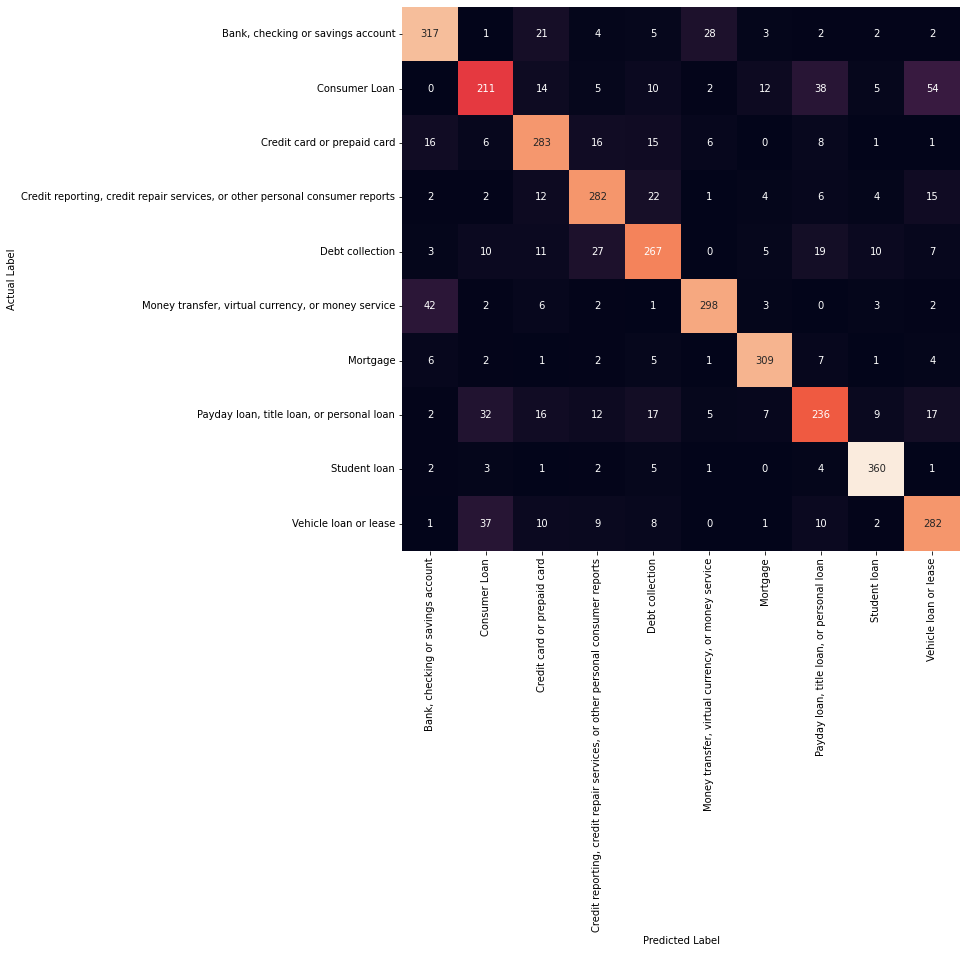

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Levity AI

The Levity AI implementation followed the [API Integration Guide](https://help.levity.ai/building-and-integrating/8q3C4bpFXdcgN65GVftWeo/how-to-integrate-with-an-api-key/oU1WwAcxXr33GGxMsDomm5)

## Preparation

In [ ]:
import requests

In [ ]:
def get_prediction(text, id):
    payload = {"text": text, "externalContext": id}
    response = requests.post('https://api.levity.ai/v1/classifiers/***********************************/classify/', data=json.dumps(payload), headers={"Authorization": "Token ************************************", "Content-Type": "application/json"}) # authorization was hidden
    output = response.json()
    return output['predictions']['results'][0]['labelName']

## Predicting

In [ ]:
predictions, y_actu, y_pred, errors, id = [], [], [], [], 0

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['text'])
    try:
      prediction = get_prediction(sample, str(id))
      y_pred.append(prediction)
      y_actu.append(row['label'])
      predictions.append([prediction, row['label'], sample])
    except:
      errors.append(id)
      print(id, sample)
    id += 1
full_time = time.time() - start_time

In [ ]:
for error in errors:
    sample = str(test.iloc[[error]]['text'].values[0])
    try:
      prediction = get_prediction(error, str(id))
      y_pred.append(prediction)
      y_actu.append(test.iloc[[error]]['label'].values[0])
      predictions.append([prediction, test.iloc[[error]]['label'].values[0], sample])
    except:
      print(sample)
    id += 1

## Results

In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
# training time will be added later manually
evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), 0, "LevityAI")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,LevityAI
1,Method,
2,Accuracy,80.2942
3,Precision (Macro Average),80.295
4,Precision (Micro Average),80.2942
5,Recall (Macro Average),80.2987
6,Recall (Micro Average),80.2942
7,F1-Score (Macro Average),80.2669
8,F1-Score (Micro Average),80.2942
9,time per document (ms),1491.67


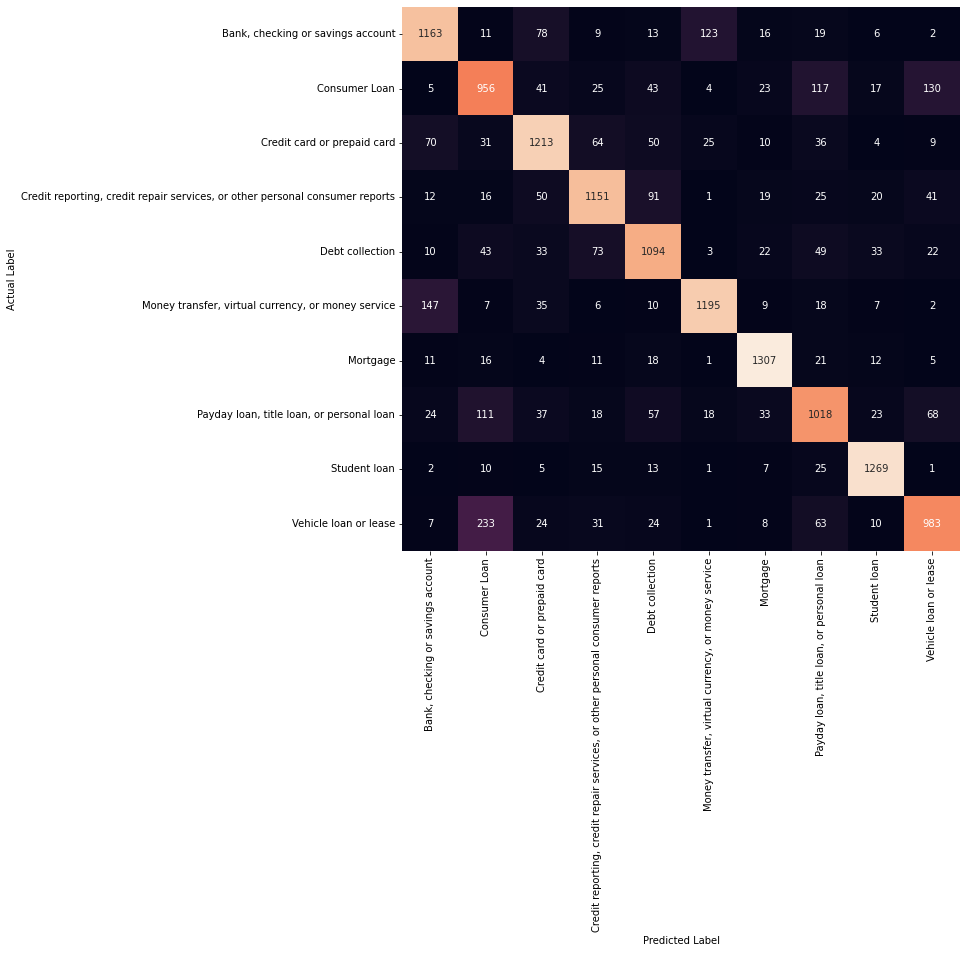

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Vertex AI

The Vertex AI implementation followed [Googles Vertex AI Guide](https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/automl-text-classification.ipynb?hl=de)

## Preparation

In [ ]:
!pip install google-cloud-aiplatform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 KB 14.5 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.0
    Uninstalling shapely-2.0.0:
      Successfully uninstalled shapely-2.0.0


In [ ]:
from google.cloud import aiplatform

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#  [START aiplatform_sdk_predict_text_classification_single_label_sample]
def predict_text_classification_single_label_sample(
    project, location, endpoint, content
):
    prediction = []
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    response = endpoint.predict(instances=[{"content": content}], parameters={})

    for prediction_ in response.predictions:
        prediction.append(prediction_)

    return prediction

## Predicting

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in test.iterrows():
    sample = str(row['text'])
    prediction = predict_text_classification_single_label_sample("classification-376510", "us-central1", "******************", sample) # charcaters were hidden
    highest_confidence_index = np.argmax(prediction[0]['confidences'])
    label = prediction[0]['displayNames'][highest_confidence_index]
    y_pred.append(label)
    y_actu.append(row['label'])
    predictions.append([label, row['label'], sample])
full_time = time.time() - start_time

results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), 291, "VertexAI")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,VertexAI
1,Method,
2,Accuracy,78.1173
3,Precision (Macro Average),77.889
4,Precision (Micro Average),78.1173
5,Recall (Macro Average),78.1039
6,Recall (Micro Average),78.1173
7,F1-Score (Macro Average),77.9489
8,F1-Score (Micro Average),78.1173
9,time per document (ms),350.91


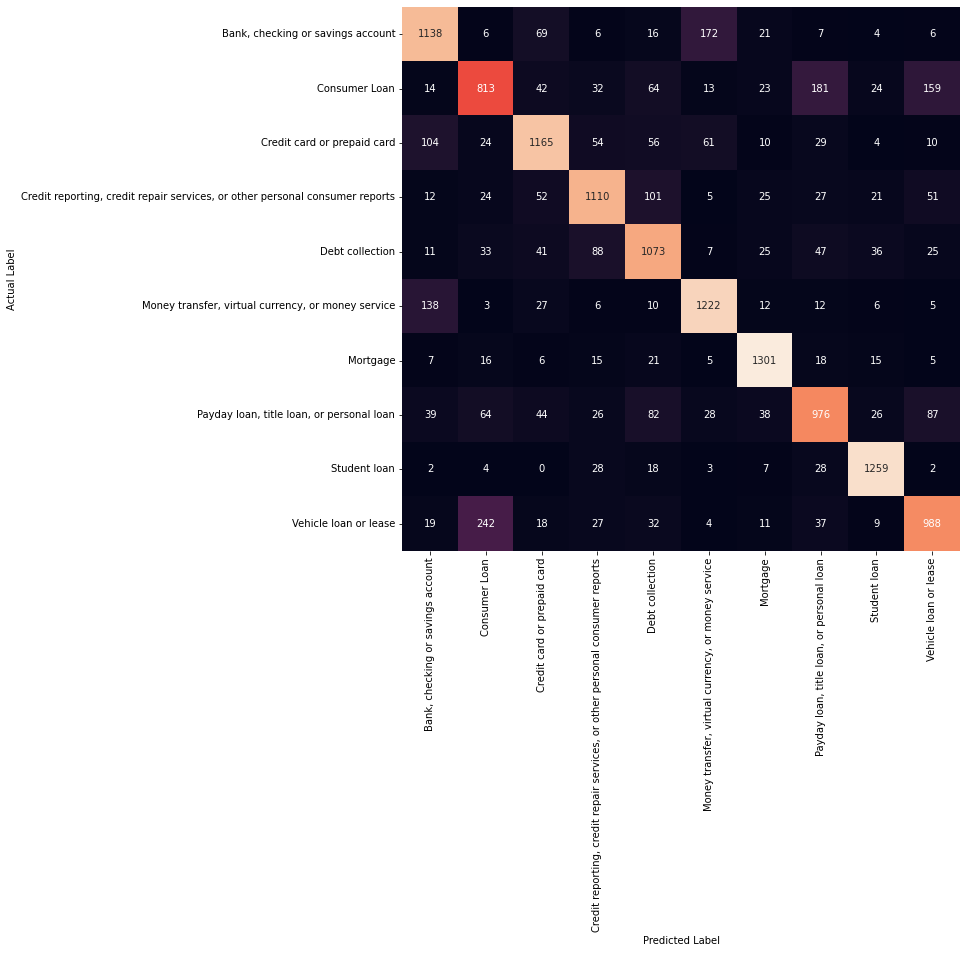

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# Open AI GPT-3

The implementation follows the [GPT-3 Guide](https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb)

## Preparation

In [ ]:
!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.5 MB/s eta 0:00:00


In [ ]:
import openai

In [ ]:
# Get the unique values in the label column and sort them
label_values = sorted(test['label'].unique())

# Map the label values to numerical labels
label_map = {value: index+1 for index, value in enumerate(label_values)}

inverted_dict = {v: k for k, v in label_map.items()}
inverted_dict

{1: 'Bank, checking or savings account',
 2: 'Consumer Loan',
 3: 'Credit card or prepaid card',
 4: 'Credit reporting, credit repair services, or other personal consumer reports',
 5: 'Debt collection',
 6: 'Money transfer, virtual currency, or money service',
 7: 'Mortgage',
 8: 'Payday loan, title loan, or personal loan',
 9: 'Student loan',
 10: 'Vehicle loan or lease'}

In [ ]:
ft_model = 'babbage:ft-personal-2023-03-09-14-41-26'
openai.api_key = '***************************************************' # key was hidden

def get_gpt_prediction(sample):
  prompt = sample + '\n\n###\n\n'
  res = openai.Completion.create(model=ft_model, prompt=prompt, max_tokens=1, temperature=0)
  numeric = res['choices'][0]['text']
  prediction = inverted_dict[int(numeric.strip())]
  return prediction

## Predicting

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['text'])
    label = get_gpt_prediction(sample[:6000]) # only 2048 tokens allowed, 1 token ≈ 4 characters (for english)
    y_pred.append(label)
    y_actu.append(row['label'])
    predictions.append([label, row['label'], sample])
full_time = time.time() - start_time

In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), 269.538, "GPT-3")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,GPT-3
1,Method,
2,Accuracy,81.2717
3,Precision (Macro Average),81.1736
4,Precision (Micro Average),81.2717
5,Recall (Macro Average),81.2607
6,Recall (Micro Average),81.2717
7,F1-Score (Macro Average),81.1845
8,F1-Score (Micro Average),81.2717
9,time per document (ms),96.82


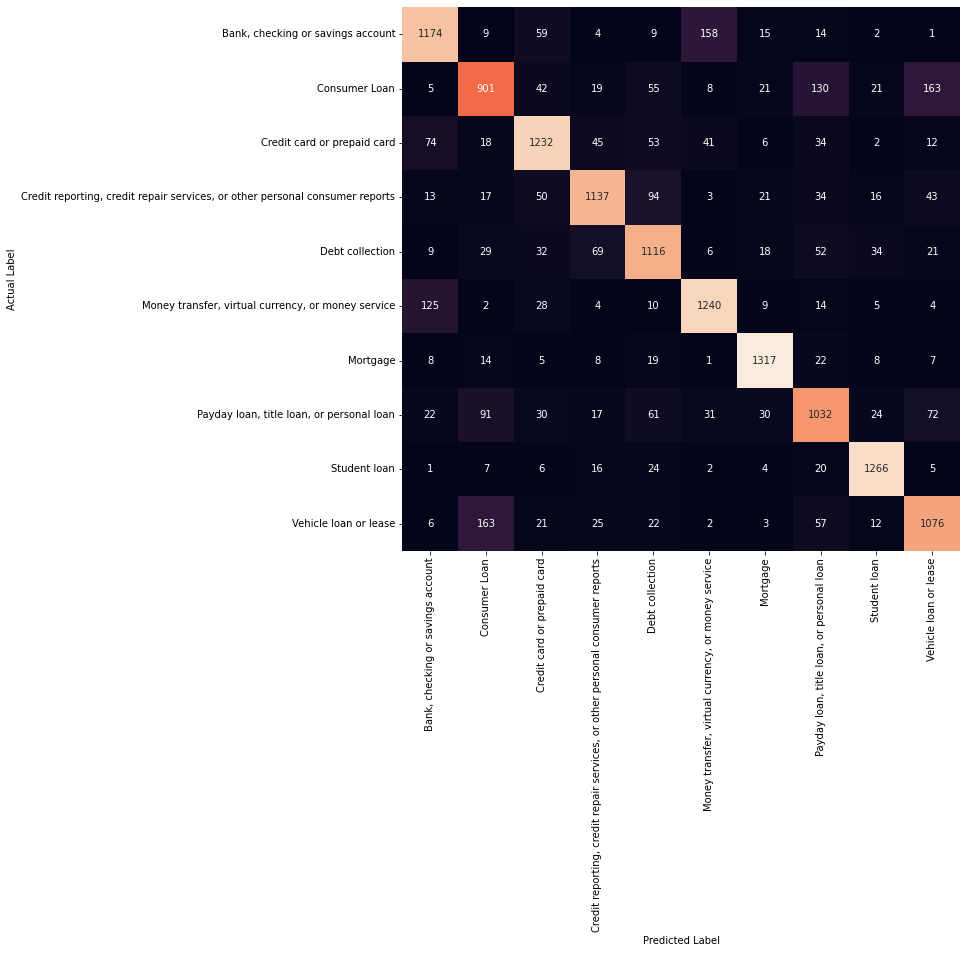

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# AWS Comprehend

This implementation follows the [AWS Comprehend Guide](https://docs.aws.amazon.com/comprehend/latest/dg/class-sync-api.html). A good example of the full training and inference process can be found [here](https://predictivehacks.com/how-to-build-a-custom-text-classification-model-with-aws-comprehend/).

## Preparation

In [ ]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.0 MB/s eta 0:00:00


In [ ]:
import boto3
from botocore.config import Config

In [ ]:
endpoint = 'arn:aws:comprehend:us-east-1:107342189580:document-classifier-endpoint/docclassendpoint10IU'

# to mitigate following error: "ClientError: An error occurred (ThrottlingException)
# when calling the ClassifyDocument operation: Rate exceeded"
config = Config(connect_timeout=20, read_timeout=60, retries={'max_attempts': 20, 'mode': 'standard'})
client = boto3.client(
    'comprehend',
    region_name='us-east-1',
    aws_access_key_id='********************', # key id was hidden
    aws_secret_access_key='****************************************', # key was hidden
    config=config
)

def get_aws_prediction(sample):
    response = client.classify_document(Text=sample, EndpointArn=endpoint)
    return response['Classes'][0]['Name']

## Predicting

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in test.iterrows():
    sample = str(row['text'])
    label = get_aws_prediction(sample[:10000]) # only 10000 characters allowed
    y_pred.append(label)
    y_actu.append(row['label'])
    predictions.append([label, row['label'], sample])
    time.sleep(3) # to mitigate the same error
full_time = time.time() - start_time

In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
# for the inference there were 10 IU used to accelerate inference, the cost calculations were instead made with
# 1 IU, which is why the inference time has to be multiplied by a factor of 10
evaluation = evaluate_model(y_actu, y_pred, round(full_time*10/test.shape[0]*1000, 2), 393, "Comprehend")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,Comprehend
1,Method,
2,Accuracy,78.0395
3,Precision (Macro Average),78.1596
4,Precision (Micro Average),78.0395
5,Recall (Macro Average),78.0286
6,Recall (Micro Average),78.0395
7,F1-Score (Macro Average),78.0106
8,F1-Score (Micro Average),78.0395
9,time per document (ms),14920.47


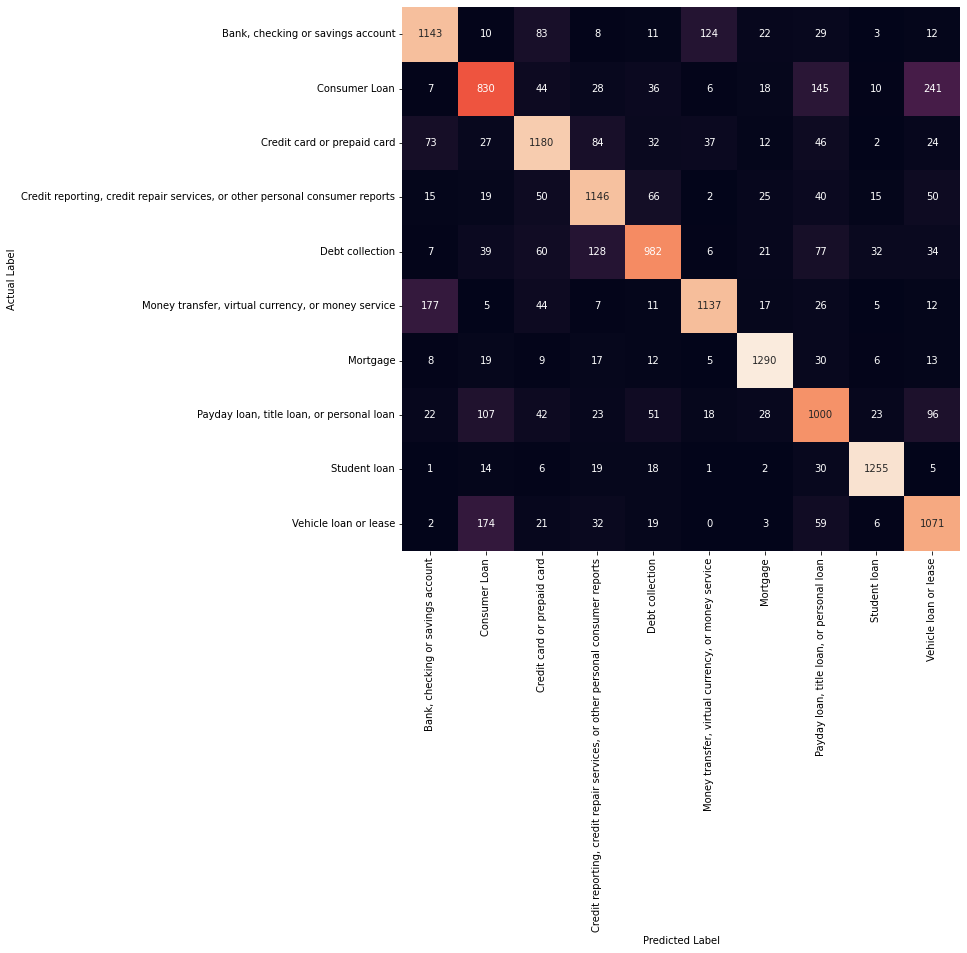

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)

# PlanetAI

The implementation was made in collaboration with the PlanetAI staff

## Preparation

In [ ]:
!pip install --upgrade protobuf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.1 which is incompatible.
tensorflow-metadata 1.12.0 requires protobuf<4,>=3.13, but you have protobuf 4.22.1 which is incompatible.
tensorboard 2.11.2 requires protobuf<4,>=3.9.2, but you have protobuf 4.22.1 which is incompatible.


In [ ]:
!unzip "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/planetai_files.zip" -d "./"

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/planetai_files.zip
  inflating: ./grpc_ssl_cert.pem     
  inflating: ./IdaConnectorDc.py     
  inflating: ./protobuf_process_image_v2.proto  
  inflating: ./protobuf_process_image_v2_pb2.py  
  inflating: ./protobuf_process_image_v2_pb2_grpc.py  
  inflating: ./RunIt.py              


In [ ]:
# custom module from planetai_files
from IdaConnectorDc import IdaConnectorDc

In [ ]:
ida = IdaConnectorDc()

def get_planetai_prediction(sample):
    pred = ida.classify(sample)
    return pred[0]["label"]

## Predicting

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['text'])
    label = get_planetai_prediction(sample)
    y_pred.append(label)
    y_actu.append(row['label'])
    predictions.append([label, row['label'], sample])
full_time = time.time() - start_time

100%|██████████| 14139/14139 [06:25<00:00, 36.71it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content'])
# results

### Evaluation

In [ ]:
labels = sorted(results.Prediction.unique())

print("tested on " + str(test.shape[0]) + " documents")

# Evaluation results
evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), 176.54, "PlanetAi")

# Print the evaluation results
eval_df = pd.DataFrame(evaluation.items())
eval_df

tested on 14139 documents


,0,1
0,Algorithm,PlanetAi
1,Method,
2,Accuracy,79.0438
3,Precision (Macro Average),79.0301
4,Precision (Micro Average),79.0438
5,Recall (Macro Average),79.035
6,Recall (Micro Average),79.0438
7,F1-Score (Macro Average),79.0124
8,F1-Score (Micro Average),79.0438
9,time per document (ms),27.24


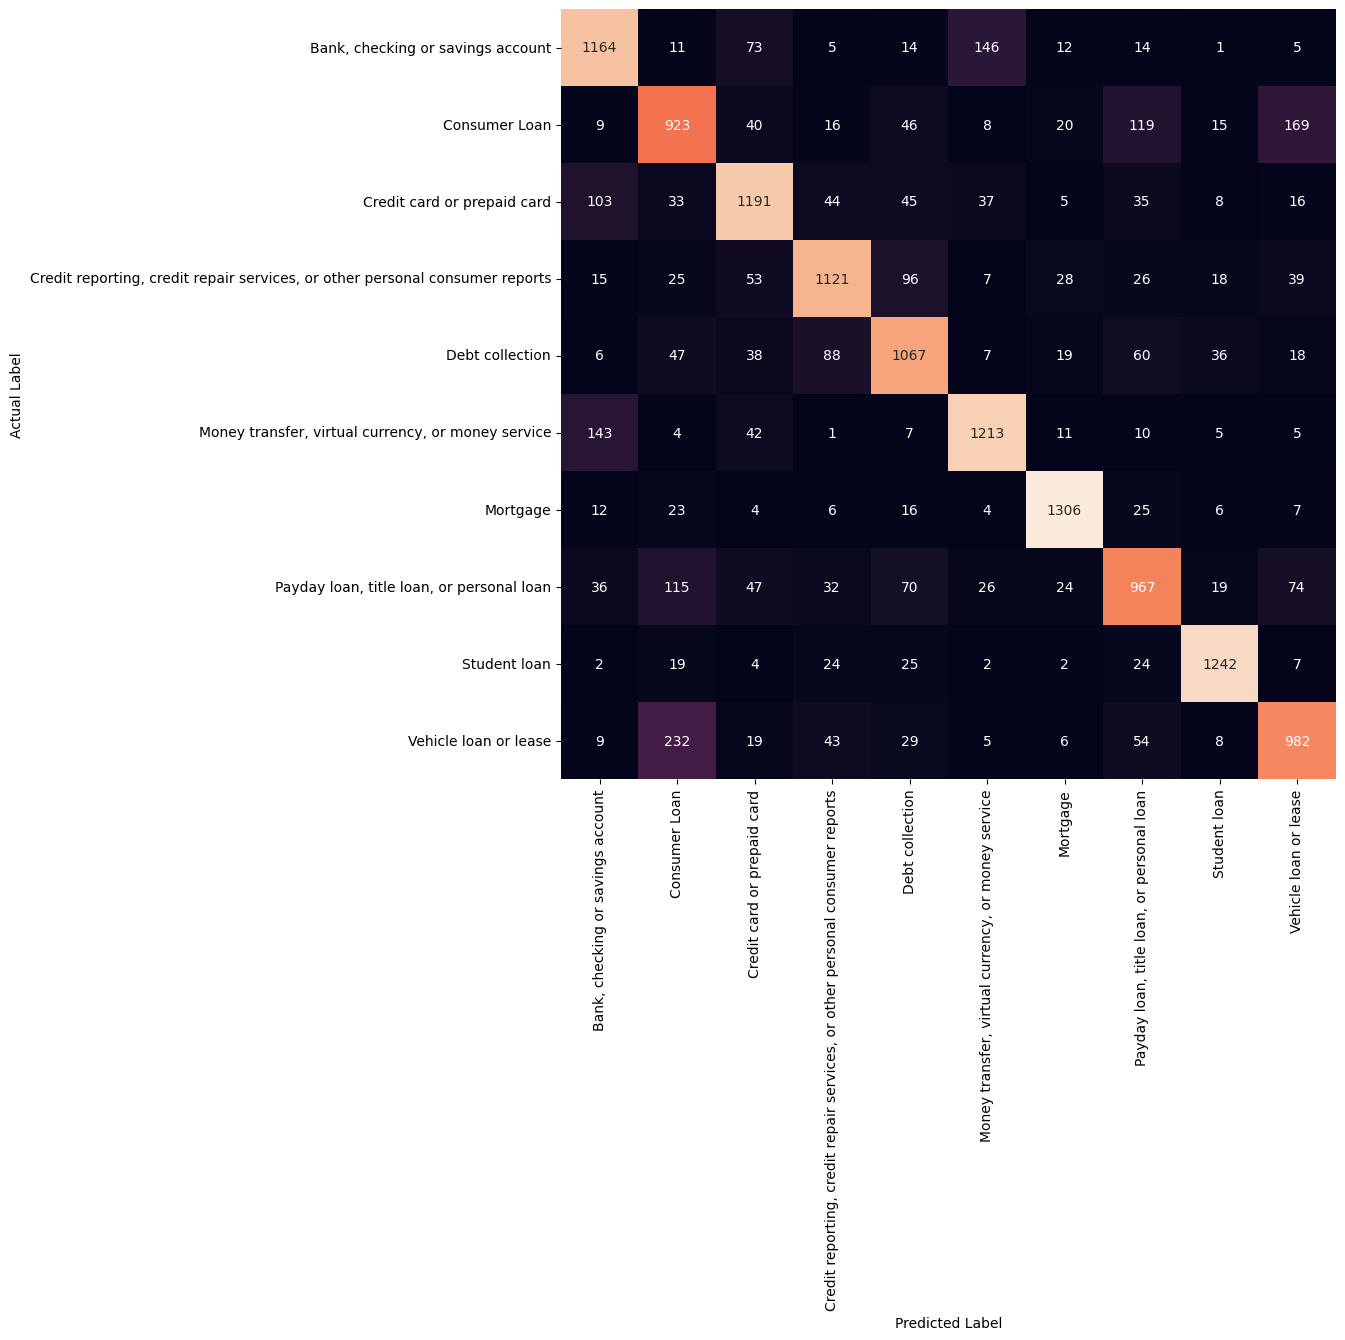

In [ ]:
plot_confusion_matrix(y_actu, y_pred, labels)